https://medium.com/@karuneshu21/how-to-resnet-in-pytorch-9acb01f36cf5
https://arxiv.org/pdf/1512.03385

In [35]:
import torch.nn as nn
import torch
from torchview import draw_graph


### Bottleneck
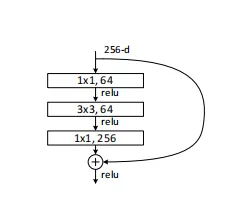


In [36]:
class Bottleneck(nn.Module):
    multiplier = 4

    def __init__(self, input_num_planes, num_planes, strd=1):
        super(Bottleneck, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=input_num_planes, out_channels=num_planes, kernel_size=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(num_planes)
        self.conv_layer2 = nn.Conv2d(in_channels=num_planes, out_channels=num_planes, kernel_size=3, stride=strd, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(num_planes)
        self.conv_layer3 = nn.Conv2d(in_channels=num_planes, out_channels=self.multiplier*num_planes, kernel_size=1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(self.multiplier*num_planes)
        self.relu = nn.ReLU()

        self.res_connnection = nn.Sequential()
        if strd > 1 or input_num_planes != self.multiplier*num_planes:
            self.res_connnection = nn.Sequential(
                nn.Conv2d(in_channels=input_num_planes, out_channels=self.multiplier*num_planes, kernel_size=1, stride=strd, bias=False),
                nn.BatchNorm2d(self.multiplier*num_planes)
            )

    def forward(self, inp):
        op = self.relu(self.batch_norm1(self.conv_layer1(inp)))
        op = self.relu(self.batch_norm2(self.conv_layer2(op)))
        op = self.batch_norm3(self.conv_layer3(op))
        op += self.res_connnection(inp)
        op = self.relu(op)
        return op


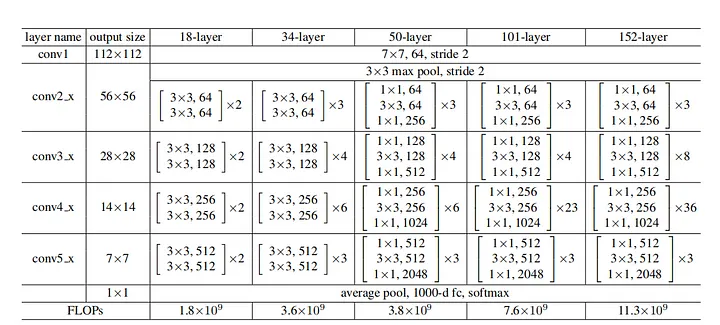

In [37]:
# resnetX = (Num of channels, repetition, Bottleneck_expansion , Bottleneck_layer)
model_parameters={}
model_parameters['resnet18'] = ([64,128,256,512],[2,2,2,2],1,False)
model_parameters['resnet34'] = ([64,128,256,512],[3,4,6,3],1,False)
model_parameters['resnet50'] = ([64,128,256,512],[3,4,6,3],4,True)
model_parameters['resnet101'] = ([64,128,256,512],[3,4,23,3],4,True)
model_parameters['resnet152'] = ([64,128,256,512],[3,8,36,3],4,True)

In [38]:

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], strd=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], strd=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], strd=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], strd=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.multiplier, num_classes)

    def _make_layer(self, block, planes, num_blocks, strd):
        layers = []
        layers.append(block(self.in_planes, planes, strd))
        self.in_planes = planes * block.multiplier
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, inp):
        op = self.relu(self.bn1(self.conv1(inp)))
        op = self.maxpool(op)
        op = self.layer1(op)
        op = self.layer2(op)
        op = self.layer3(op)
        op = self.layer4(op)
        op = self.avgpool(op)
        op = torch.flatten(op, 1)
        op = self.fc(op)
        return op

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

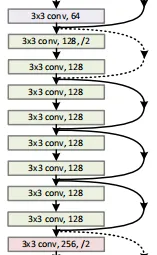

In [39]:
class Bottleneck(nn.Module):

    def __init__(self,in_channels,intermediate_channels,expansion,is_Bottleneck,stride):
        
        """
        Creates a Bottleneck with conv 1x1->3x3->1x1 layers.
        
        Note:
          1. Addition of feature maps occur at just before the final ReLU with the input feature maps
          2. if input size is different from output, select projected mapping or else identity mapping.
          3. if is_Bottleneck=False (3x3->3x3) are used else (1x1->3x3->1x1). Bottleneck is required for resnet-50/101/152
        Args:
            in_channels (int) : input channels to the Bottleneck
            intermediate_channels (int) : number of channels to 3x3 conv 
            expansion (int) : factor by which the input #channels are increased
            stride (int) : stride applied in the 3x3 conv. 2 for first Bottleneck of the block and 1 for remaining

        Attributes:
            Layer consisting of conv->batchnorm->relu

        """

        super(Bottleneck,self).__init__()

        self.expansion = expansion
        self.in_channels = in_channels
        self.intermediate_channels = intermediate_channels
        self.is_Bottleneck = is_Bottleneck
        
        # i.e. if dim(x) == dim(F) => Identity function
        if self.in_channels==self.intermediate_channels*self.expansion:
            self.identity = True
        else:
            self.identity = False
            projection_layer = []
            projection_layer.append(nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels*self.expansion, kernel_size=1, stride=stride, padding=0, bias=False ))
            projection_layer.append(nn.BatchNorm2d(self.intermediate_channels*self.expansion))
            # Only conv->BN and no ReLU
            # projection_layer.append(nn.ReLU())
            self.projection = nn.Sequential(*projection_layer)

        # commonly used relu
        self.relu = nn.ReLU()

        # is_Bottleneck = True for all ResNet 50+
        if self.is_Bottleneck:
            # bottleneck
            # 1x1
            self.conv1_1x1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False )
            self.batchnorm1 = nn.BatchNorm2d(self.intermediate_channels)
            
            # 3x3
            self.conv2_3x3 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False )
            self.batchnorm2 = nn.BatchNorm2d(self.intermediate_channels)
            
            # 1x1
            self.conv3_1x1 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels*self.expansion, kernel_size=1, stride=1, padding=0, bias=False )
            self.batchnorm3 = nn.BatchNorm2d( self.intermediate_channels*self.expansion )
        
        else:
            # basicblock
            # 3x3
            self.conv1_3x3 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False )
            self.batchnorm1 = nn.BatchNorm2d(self.intermediate_channels)
            
            # 3x3
            self.conv2_3x3 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=1, padding=1, bias=False )
            self.batchnorm2 = nn.BatchNorm2d(self.intermediate_channels)

    def forward(self,x):
        # input stored to be added before the final relu
        in_x = x

        if self.is_Bottleneck:
            # conv1x1->BN->relu
            x = self.relu(self.batchnorm1(self.conv1_1x1(x)))
            
            # conv3x3->BN->relu
            x = self.relu(self.batchnorm2(self.conv2_3x3(x)))
            
            # conv1x1->BN
            x = self.batchnorm3(self.conv3_1x1(x))
        
        else:
            # conv3x3->BN->relu
            x = self.relu(self.batchnorm1(self.conv1_3x3(x)))

            # conv3x3->BN
            x = self.batchnorm2(self.conv2_3x3(x))


        # identity or projected mapping
        if self.identity:
            x += in_x
        else:
            x += self.projection(in_x)

        # final relu
        x = self.relu(x)
        
        return x

def test_Bottleneck():
    x = torch.randn(1,64,112,112)
    model = Bottleneck(64,64,4,True,2)
    print(model(x).shape)
    del model

test_Bottleneck()

torch.Size([1, 256, 56, 56])


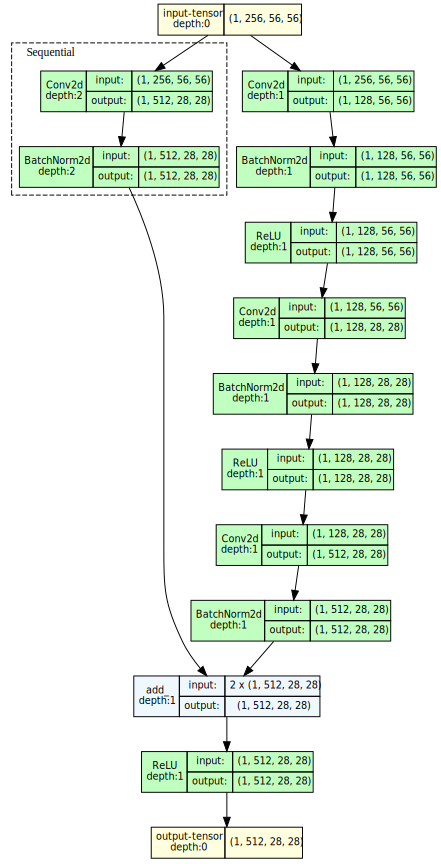

In [40]:
# Projected Mapping Block
model = Bottleneck(256,128,4,True,2)
model_graph = draw_graph(model, input_size=(1,256,56,56), expand_nested=True)
model_graph.visual_graph

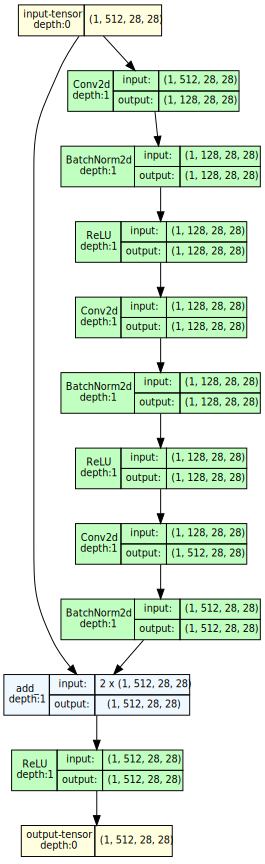

In [41]:
# Identity Mapping Block
model = Bottleneck(512,128,4,True,1)
model_graph = draw_graph(model, input_size=(1,512,28,28), expand_nested=True)
model_graph.visual_graph

In [42]:
class ResNet(nn.Module):

    def __init__(self, resnet_variant,in_channels,num_classes):
        """
        Creates the ResNet architecture based on the provided variant. 18/34/50/101 etc.
        Based on the input parameters, define the channels list, repeatition list along with expansion factor(4) and stride(3/1)
        using _make_blocks method, create a sequence of multiple Bottlenecks
        Average Pool at the end before the FC layer 

        Args:
            resnet_variant (list) : eg. [[64,128,256,512],[3,4,6,3],4,True]
            in_channels (int) : image channels (3)
            num_classes (int) : output #classes 

        Attributes:
            Layer consisting of conv->batchnorm->relu

        """
        super(ResNet,self).__init__()
        self.channels_list = resnet_variant[0]
        self.repeatition_list = resnet_variant[1]
        self.expansion = resnet_variant[2]
        self.is_Bottleneck = resnet_variant[3]

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False )
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.block1 = self._make_blocks( 64 , self.channels_list[0], self.repeatition_list[0], self.expansion, self.is_Bottleneck, stride=1 )
        self.block2 = self._make_blocks( self.channels_list[0]*self.expansion , self.channels_list[1], self.repeatition_list[1], self.expansion, self.is_Bottleneck, stride=2 )
        self.block3 = self._make_blocks( self.channels_list[1]*self.expansion , self.channels_list[2], self.repeatition_list[2], self.expansion, self.is_Bottleneck, stride=2 )
        self.block4 = self._make_blocks( self.channels_list[2]*self.expansion , self.channels_list[3], self.repeatition_list[3], self.expansion, self.is_Bottleneck, stride=2 )

        self.average_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear( self.channels_list[3]*self.expansion , num_classes)



    def forward(self,x):
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.block1(x)
        
        x = self.block2(x)
        
        x = self.block3(x)
        
        x = self.block4(x)
        
        x = self.average_pool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        
        return x

    def _make_blocks(self,in_channels,intermediate_channels,num_repeat, expansion, is_Bottleneck, stride):
        
        """
        Args:
            in_channels : #channels of the Bottleneck input
            intermediate_channels : #channels of the 3x3 in the Bottleneck
            num_repeat : #Bottlenecks in the block
            expansion : factor by which intermediate_channels are multiplied to create the output channels
            is_Bottleneck : status if Bottleneck in required
            stride : stride to be used in the first Bottleneck conv 3x3

        Attributes:
            Sequence of Bottleneck layers

        """
        layers = [] 

        layers.append(Bottleneck(in_channels,intermediate_channels,expansion,is_Bottleneck,stride=stride))
        for num in range(1,num_repeat):
            layers.append(Bottleneck(intermediate_channels*expansion,intermediate_channels,expansion,is_Bottleneck,stride=1))

        return nn.Sequential(*layers)


def test_ResNet(params):
    model = ResNet( params , in_channels=3, num_classes=1000)
    x = torch.randn(1,3,224,224)
    output = model(x)
    print(output.shape)
    return model

architecture = 'resnet50'
model = test_ResNet(model_parameters[architecture])


torch.Size([1, 1000])


In [43]:
from torchvision.models import resnet50,ResNet50_Weights
torchvision_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

In [44]:
from pytorchsummary import summary
print(summary((3,224,224), torchvision_model))

               Layer	Output Shape        	    Kernal Shape    	#params             	#(weights + bias)   	requires_grad
------------------------------------------------------------------------------------------------------------------------------------------------------
            Conv2d-1	[1, 64, 112, 112]   	   [64, 3, 7, 7]    	9408                	(9408+0)            	   True   
       BatchNorm2d-2	[1, 64, 112, 112]   	        [64]        	128                 	(64 + 64)           	True True 
              ReLU-3	[1, 64, 112, 112]   	                    	                    	                    	          
         MaxPool2d-4	[1, 64, 56, 56]     	                    	                    	                    	          
            Conv2d-5	[1, 64, 56, 56]     	   [64, 64, 1, 1]   	4096                	(4096+0)            	   True   
       BatchNorm2d-6	[1, 64, 56, 56]     	        [64]        	128                 	(64 + 64)           	True True 
              ReLU-7	[1, 64, 56, 5

In [45]:
from pytorchsummary import summary
print(summary((3,224,224), model))

               Layer	Output Shape        	    Kernal Shape    	#params             	#(weights + bias)   	requires_grad
------------------------------------------------------------------------------------------------------------------------------------------------------
            Conv2d-1	[1, 64, 112, 112]   	   [64, 3, 7, 7]    	9408                	(9408+0)            	   True   
       BatchNorm2d-2	[1, 64, 112, 112]   	        [64]        	128                 	(64 + 64)           	True True 
              ReLU-3	[1, 64, 112, 112]   	                    	                    	                    	          
         MaxPool2d-4	[1, 64, 56, 56]     	                    	                    	                    	          
            Conv2d-5	[1, 64, 56, 56]     	   [64, 64, 1, 1]   	4096                	(4096+0)            	   True   
       BatchNorm2d-6	[1, 64, 56, 56]     	        [64]        	128                 	(64 + 64)           	True True 
              ReLU-7	[1, 64, 56, 5

### Side by Side comparison
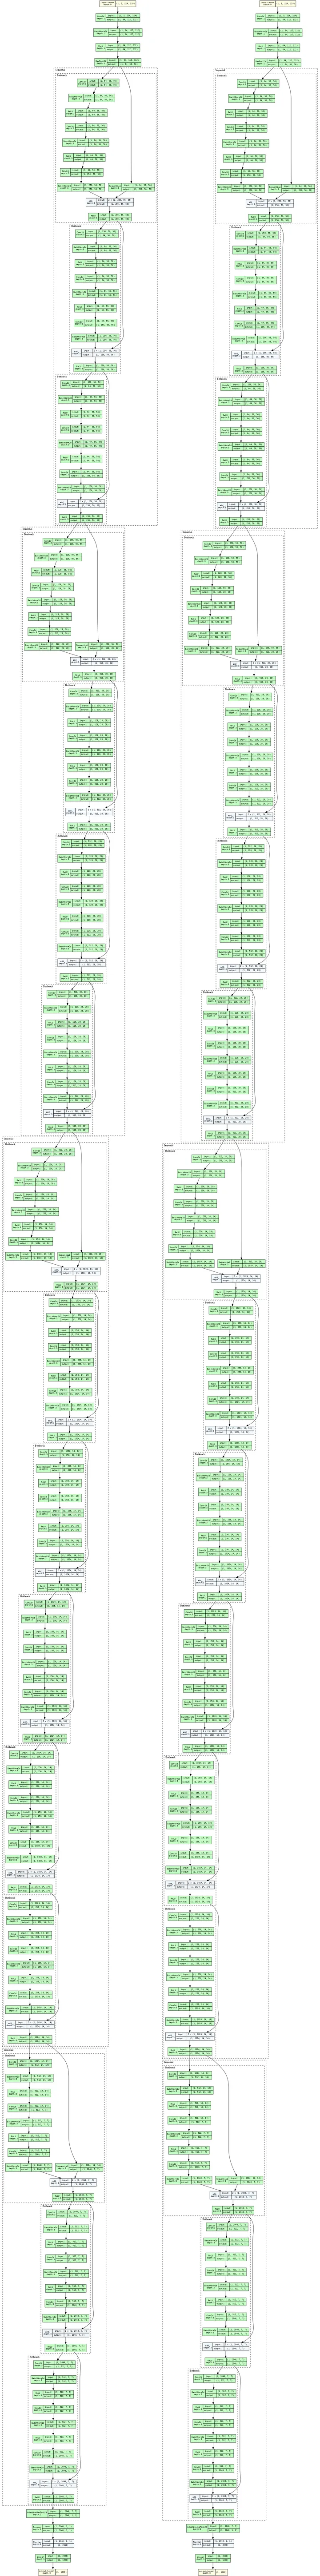

In [46]:
from torchview import draw_graph
model_graph_tv = draw_graph(torchvision_model, input_size=(1,3,224,224), expand_nested=True)
model_graph = draw_graph(model, input_size=(1,3,224,224), expand_nested=True)


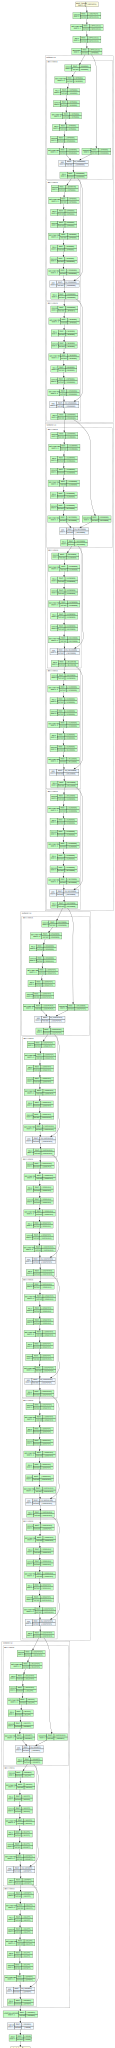

In [47]:
model_graph_tv.visual_graph

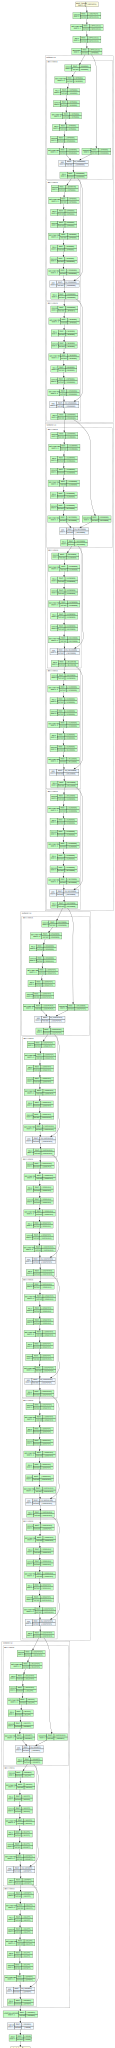

In [48]:
model_graph.visual_graph